In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ppedata/Final_PPE_Dataset/README.dataset.txt
/kaggle/input/ppedata/Final_PPE_Dataset/README.roboflow.txt
/kaggle/input/ppedata/Final_PPE_Dataset/data.yaml
/kaggle/input/ppedata/Final_PPE_Dataset/BetterNamingFormat.py
/kaggle/input/ppedata/Final_PPE_Dataset/valid/labels/valid_Safety_Gloves_000759.txt
/kaggle/input/ppedata/Final_PPE_Dataset/valid/labels/valid_Safety_Vest_000383.txt
/kaggle/input/ppedata/Final_PPE_Dataset/valid/labels/valid_Hardhat_000124.txt
/kaggle/input/ppedata/Final_PPE_Dataset/valid/labels/valid_Hardhat_000385.txt
/kaggle/input/ppedata/Final_PPE_Dataset/valid/labels/valid_Hardhat_000269.txt
/kaggle/input/ppedata/Final_PPE_Dataset/valid/labels/valid_Safety_Mask_000603.txt
/kaggle/input/ppedata/Final_PPE_Dataset/valid/labels/valid_Hardhat_000682.txt
/kaggle/input/ppedata/Final_PPE_Dataset/valid/labels/valid_Safety_Mask_000223.txt
/kaggle/input/ppedata/Final_PPE_Dataset/valid/labels/valid_Safety_Gloves_000506.txt
/kaggle/input/ppedata/Final_PPE_Dataset/val

In [2]:
# Install YOLOv8
!pip install ultralytics

# # Clone the YOLOv11 repository if needed
# !git clone https://github.com/ultralytics/ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 17.7 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 2.0 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 28.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.1 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 77.8 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.8.93
    Uninstalling nvidia-nvjitlink-cu12-12.8.93:
      Successfully uninstalled nvidia-nvjitlink-cu12-12.8.93
  Attempting uninstall: nvidia-curand-cu12
    Found exi

Checking train dataset:
Found 2654 images and 2654 label files

Checking validation dataset:
Found 765 images and 765 label files

Checking test dataset:
Found 381 images and 381 label files

Visualizing sample from training set:


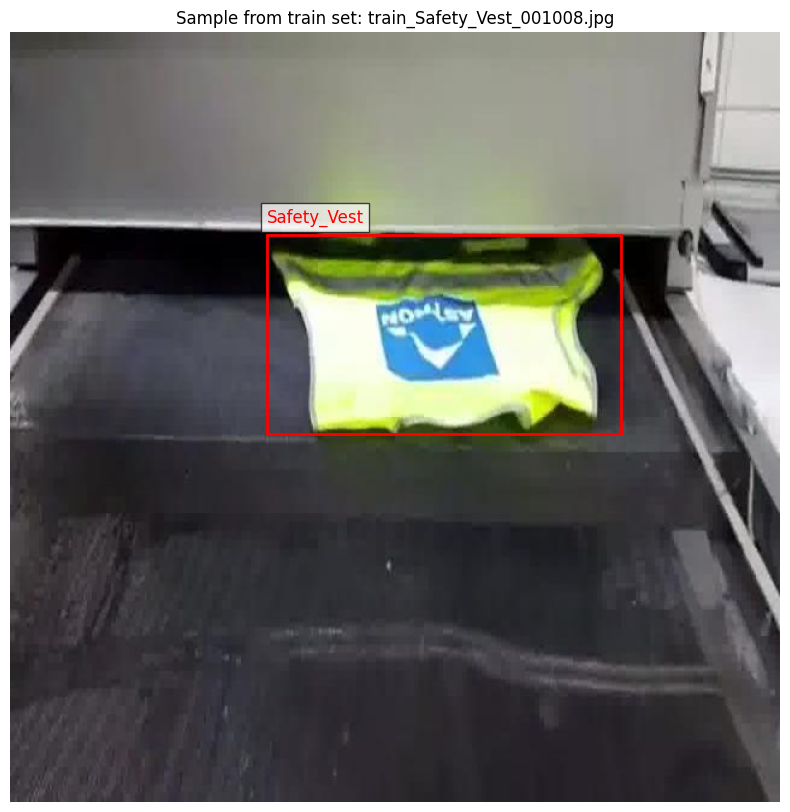


Visualizing sample from validation set:


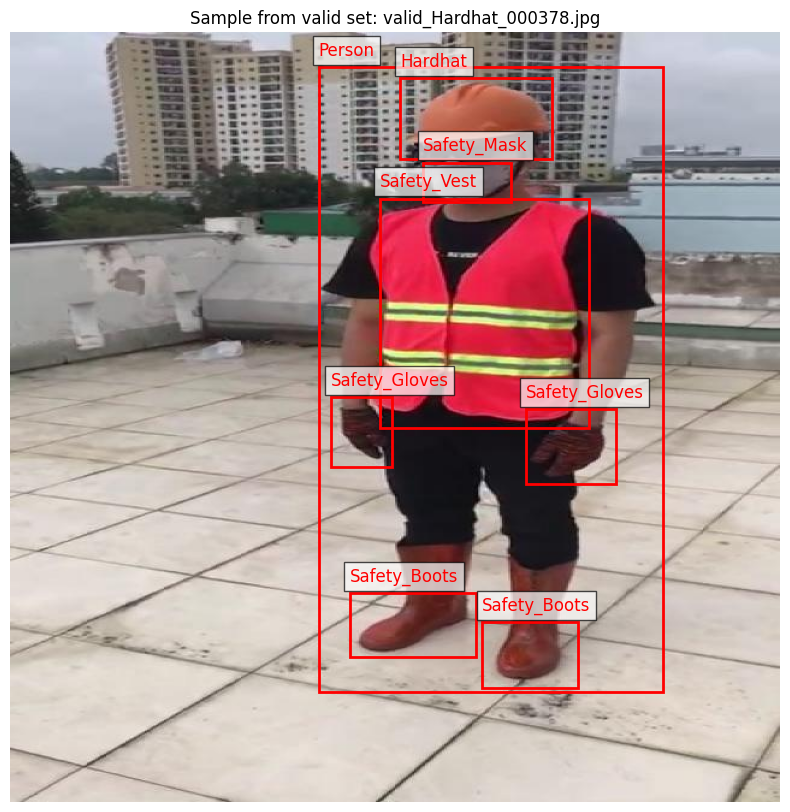


Counting instances of each class in training set:
Hardhat: 1409
Person: 1125
Safety_Boots: 1608
Safety_Gloves: 1924
Safety_Mask: 1583
Safety_Vest: 1165


In [3]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import cv2
from PIL import Image
import glob

# Set paths based on Kaggle's input directory structure
dataset_path = '/kaggle/input/ppedata/Final_PPE_Dataset'  # Update this path as needed
train_path = os.path.join(dataset_path, 'train')
valid_path = os.path.join(dataset_path, 'valid')
test_path = os.path.join(dataset_path, 'test')

# Class names
class_names = ['Hardhat', 'Person', 'Safety_Boots', 'Safety_Gloves', 'Safety_Mask', 'Safety_Vest']

# Function to check dataset structure
def check_dataset_structure(path):
    images_path = os.path.join(path, 'images')
    labels_path = os.path.join(path, 'labels')
    
    if not os.path.exists(images_path):
        print(f"WARNING: Images directory not found at {images_path}")
        return 0, 0
    
    if not os.path.exists(labels_path):
        print(f"WARNING: Labels directory not found at {labels_path}")
        return len(os.listdir(images_path)), 0
    
    image_files = os.listdir(images_path)
    label_files = os.listdir(labels_path)
    
    print(f"Found {len(image_files)} images and {len(label_files)} label files")
    return len(image_files), len(label_files)

# Check dataset structure
print("Checking train dataset:")
train_images, train_labels = check_dataset_structure(train_path)
print("\nChecking validation dataset:")
valid_images, valid_labels = check_dataset_structure(valid_path)
print("\nChecking test dataset:")
test_images, test_labels = check_dataset_structure(test_path)

# Function to visualize an image with its bounding boxes
def visualize_sample(split='train'):
    if split == 'train':
        path = train_path
    elif split == 'valid':
        path = valid_path
    else:
        path = test_path
    
    images_path = os.path.join(path, 'images')
    labels_path = os.path.join(path, 'labels')
    
    image_files = os.listdir(images_path)
    if not image_files:
        print(f"No images found in {images_path}")
        return
    
    # Select a random image
    img_file = random.choice(image_files)
    img_path = os.path.join(images_path, img_file)
    
    # Load the image
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    height, width, _ = img.shape
    
    # Check if corresponding label file exists
    label_file = os.path.splitext(img_file)[0] + '.txt'
    label_path = os.path.join(labels_path, label_file)
    
    plt.figure(figsize=(10, 10))
    plt.imshow(img)
    
    if os.path.exists(label_path):
        # Read and plot annotations
        with open(label_path, 'r') as f:
            for line in f.readlines():
                values = line.strip().split()
                class_id = int(values[0])
                x_center = float(values[1]) * width
                y_center = float(values[2]) * height
                bbox_width = float(values[3]) * width
                bbox_height = float(values[4]) * height
                
                x1 = int(x_center - bbox_width/2)
                y1 = int(y_center - bbox_height/2)
                x2 = int(x_center + bbox_width/2)
                y2 = int(y_center + bbox_height/2)
                
                # Draw rectangle
                plt.gca().add_patch(plt.Rectangle((x1, y1), x2-x1, y2-y1, fill=False, edgecolor='red', linewidth=2))
                plt.text(x1, y1-10, class_names[class_id], color='red', fontsize=12, 
                         bbox=dict(facecolor='white', alpha=0.7))
    else:
        plt.title(f"Image: {img_file} (No label file found)")
        
    plt.title(f"Sample from {split} set: {img_file}")
    plt.axis('off')
    plt.show()
    
    return img_file

# Try to visualize a sample from each split
try:
    print("\nVisualizing sample from training set:")
    train_sample = visualize_sample('train')
    print("\nVisualizing sample from validation set:")
    valid_sample = visualize_sample('valid')
except Exception as e:
    print(f"Error visualizing samples: {e}")

# Count instances of each class in the training set
def count_classes(path):
    labels_path = os.path.join(path, 'labels')
    if not os.path.exists(labels_path):
        print(f"Labels directory not found at {labels_path}")
        return None
    
    class_counts = {i: 0 for i in range(len(class_names))}
    
    for label_file in os.listdir(labels_path):
        if not label_file.endswith('.txt'):
            continue
        
        label_path = os.path.join(labels_path, label_file)
        with open(label_path, 'r') as f:
            for line in f.readlines():
                values = line.strip().split()
                class_id = int(values[0])
                class_counts[class_id] += 1
    
    return class_counts

print("\nCounting instances of each class in training set:")
train_class_counts = count_classes(train_path)
if train_class_counts:
    for class_id, count in train_class_counts.items():
        print(f"{class_names[class_id]}: {count}")

In [4]:
import yaml

dataset_config = {
    'train': '/kaggle/input/ppedata/Final_PPE_Dataset/train/images',
    'val': '/kaggle/input/ppedata/Final_PPE_Dataset/valid/images',
    'test': '/kaggle/input/ppedata/Final_PPE_Dataset/test/images',
    'nc': 6,
    'names': ['Hardhat', 'Person', 'Safety_Boots', 'Safety_Gloves', 'Safety_Mask', 'Safety_Vest']
}

with open('/kaggle/working/ppe_dataset.yaml', 'w') as f:
    yaml.dump(dataset_config, f, default_flow_style=False)

print("Dataset configuration saved to /kaggle/working/ppe_dataset.yaml")

Dataset configuration saved to /kaggle/working/ppe_dataset.yaml


In [ ]:
from ultralytics import YOLO
import time

# Initialize the model
model = YOLO('yolov8n.pt')  # Use YOLOv8 nano model

# Custom callback to print detailed information per epoch
def on_train_epoch_end(trainer):
    epoch = trainer.epoch
    metrics = trainer.metrics
    
    # Extract key metrics
    box_loss = metrics.get('train/box_loss', 0)
    cls_loss = metrics.get('train/cls_loss', 0)
    dfl_loss = metrics.get('train/dfl_loss', 0)
    total_loss = box_loss + cls_loss + dfl_loss
    
    # Print epoch information
    print(f"\nEpoch {epoch} completed:")
    # print(f"  Box Loss: {box_loss:.4f}")
    # print(f"  Class Loss: {cls_loss:.4f}")
    # print(f"  DFL Loss: {dfl_loss:.4f}")
    print(f"  Total Loss: {total_loss:.4f}")
    
    # If validation was performed
    if hasattr(metrics, 'map50'):
        print(f"  mAP@50: {metrics.map50:.4f}")
        print(f"  mAP@50-95: {metrics.map:.4f}")

# Register the callback
model.add_callback("on_train_epoch_end", on_train_epoch_end)

# Record start time
start_time = time.time()

# Train the model with additional parameters
results = model.train(
    data='/kaggle/working/ppe_dataset.yaml',
    epochs=50,            # Number of training epochs
    imgsz=640,             # Image size
    batch=16,              # Batch size
    workers=4,             # Number of worker threads
    patience=10,           # Early stopping patience
    device=0,              # GPU device (0) or CPU (-1)
    project='PPE_Detection', # Project name
    name='YOLOv8_Training', # Run name
    augment=True,          # Enable built-in data augmentation
    optimizer='Adam',      # Use Adam optimizer
    lr0=0.001,             # Initial learning rate
    verbose=True           # Enable verbose output
)

# Calculate training time
training_time = time.time() - start_time
hours, remainder = divmod(training_time, 3600)
minutes, seconds = divmod(remainder, 60)
print(f"\nTraining completed in {int(hours)}h {int(minutes)}m {int(seconds)}s")

# Print final performance metrics
print("\nFinal Model Performance:")
print(f"mAP50-95: {results.maps[0]:.4f}")
print(f"mAP50: {results.map50:.4f}")
print(f"mAP75: {results.map75:.4f}")

# Save the trained model
print("\nExporting model...")
model.export(format='onnx')  # Export to ONNX format
print("Model exported successfully.")

In [ ]:
print("\nExporting model...")
model.export(format='onnx')  # Export to ONNX format
print("Model exported successfully.")

In [5]:
from ultralytics import YOLO
import time
# Load the trained model
# model_path = '/kaggle/working/PPE_Detection/YOLOv8_Training/weights/best.onnx'
# model = YOLO(model_path)
model = YOLO('/kaggle/input/ppe-model/best.onnx')
# print(f"Loaded model from {model_path}")

# Define paths
test_path = '/kaggle/input/ppedata/Final_PPE_Dataset/test'
yaml_path = '/kaggle/working/ppe_dataset.yaml'

# Step 1: Evaluate the model on the test set
print("\nEvaluating model on test set...")
test_results = model.val(data=yaml_path, split='test')
print("\nTest Set Performance:")
print(f"mAP50-95: {test_results.box.map:.4f}")
print(f"mAP50: {test_results.box.map50:.4f}")
print(f"mAP75: {test_results.box.map75:.4f}")

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
WARNING ⚠️ Unable to automatically guess model task, assuming 'task=detect'. Explicitly define task for your model, i.e. 'task=detect', 'segment', 'classify','pose' or 'obb'.

Evaluating model on test set...
Ultralytics 8.3.169 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla T4, 15095MiB)
Loading /kaggle/input/ppe-model/best.onnx for ONNX Runtime inference...
requirements: Ultralytics requirement ['onnxruntime-gpu'] not found, attempting AutoUpdate...


Using Python 3.11.11 environment at: /usr
Resolved 20 packages in 235ms



requirements: AutoUpdate success ✅ 3.9s
WARNING ⚠️ requirements: Restart runtime or rerun command for updates to take effect

Using ONNX Runtime CUDAExecutionProvider


 Downloaded onnxruntime-gpu
Prepared 3 packages in 3.11s
Installed 3 packages in 10ms
 + coloredlogs==15.0.1
 + humanfriendly==10.0
 + onnxruntime-gpu==1.22.0


Setting batch=1 input of shape (1, 3, 640, 640)


2025-07-26 12:15:41.963293939 [W:onnxruntime:, transformer_memcpy.cc:83 ApplyImpl] 4 Memcpy nodes are added to the graph main_graph for CUDAExecutionProvider. It might have negative impact on performance (including unable to run CUDA graph). Set session_options.log_severity_level=1 to see the detail logs before this message.


100%|██████████| 755k/755k [00:00<00:00, 17.1MB/s]


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 10.7±1.3 MB/s, size: 30.3 KB)


val: Scanning /kaggle/input/ppedata/Final_PPE_Dataset/test/labels... 381 images, 0 backgrounds, 0 corrupt: 100%|██████████| 381/381 [00:01<00:00, 375.61it/s]

WARNING ⚠️ val: Cache directory /kaggle/input/ppedata/Final_PPE_Dataset/test is not writeable, cache not saved.
WARNING ⚠️ Box and segment counts should be equal, but got len(segments) = 8, len(boxes) = 1251. To resolve this only boxes will be used and all segments will be removed. To avoid this please supply either a detect or segment dataset, not a detect-segment mixed dataset.



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 381/381 [00:06<00:00, 58.67it/s]
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all        381       1251       0.91      0.882      0.939      0.691
               Hardhat        178        205      0.953      0.971      0.986      0.816
                Person        137        165      0.922      0.909      0.961      0.812
          Safety_Boots        112        228      0.829      0.768      0.866      0.533
         Safety_Gloves        140        253      0.912       0.85       0.91      0.635
           Safety_Mask        210        220      0.899      0.889      0.943      0.577
           Safety_Vest        139        180      0.945      0.906      0.965      0.771
Speed: 0.5ms preprocess, 6.0ms inference, 0.0ms loss, 3.0ms postprocess per image
Results saved to runs/detect/val

Test Set Performance:
mAP50-95: 0.6908
mAP50: 0.9385
mAP75: 0.7386


In [7]:
!pip install mediapipe --quiet

In [30]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import mediapipe as mp
from ultralytics import YOLO

# Load YOLOv8 model
# model = YOLO('/path/to/best.pt')  # Uncomment and provide your path

# Mediapipe pose detector
mp_pose = mp.solutions.pose
pose_detector = mp_pose.Pose(static_image_mode=True)

# Class ID for Hardhat (adjust if different)
helmet_class_id = 0


def run_combined_detection(image_path, model):
    image_bgr = cv2.imread(image_path)
    if image_bgr is None:
        print("❌ Could not load image.")
        return

    image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
    h, w, _ = image_rgb.shape

    # Run YOLOv8 prediction
    results = model.predict(image_path, conf=0.25, save=False)[0]
    helmet_bbox = None
    helmet_conf = 0

    # Start from original image for drawing
    im_array = results.plot()  # Get YOLO detections with boxes drawn
    image_combined = im_array.copy()

    # Find helmet box (first one)
    for box in results.boxes:
        cls = int(box.cls.item())
        conf = float(box.conf.item())
        if cls == helmet_class_id and conf > helmet_conf:
            helmet_conf = conf
            helmet_bbox = box.xyxy[0].cpu().numpy().astype(int)

    # Run pose estimation
    pose_results = pose_detector.process(image_rgb)
    # helmet_status = "Helmet not detected"
    helmet_status = "."
    color = (0, 255, 255)

    if helmet_bbox is not None:
        x1, y1, x2, y2 = helmet_bbox
        margin = 30
        x1, y1, x2, y2 = max(0, x1 - margin), max(0, y1 - margin), min(w, x2 + margin), min(h, y2 + margin)

        # Check for pose
        if pose_results.pose_landmarks:
            nose = pose_results.pose_landmarks.landmark[mp_pose.PoseLandmark.NOSE]
            x_head, y_head = int(nose.x * w), int(nose.y * h)

            # Draw head point
            cv2.circle(image_combined, (x_head, y_head), 6, (255, 0, 0), -1)

            if x1 <= x_head <= x2 and y1 <= y_head <= y2:
                helmet_status = "Helmet is worn correctly"
                color = (0, 255, 0)
            else:
                helmet_status = "Helmet NOT worn properly"
                color = (0, 0, 255)

        else:
            helmet_status = "Helmet detected, but pose not found"
            color = (0, 165, 255)

        # Draw helmet box manually again with status color
        cv2.rectangle(image_combined, (x1, y1), (x2, y2), color, 3)

    # Draw status text
    cv2.putText(image_combined, helmet_status, (30, 50), cv2.FONT_HERSHEY_SIMPLEX, 1.0, color, 3)

    # Display final merged result
    plt.figure(figsize=(12, 8))
    plt.imshow(cv2.cvtColor(image_combined, cv2.COLOR_BGR2RGB))
    plt.title("YOLO + Helmet Pose Check")
    plt.axis('off')
    plt.show()


W0000 00:00:1753533738.546092     272 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1753533738.599454     272 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.



image 1/1 /kaggle/input/ppedata/Final_PPE_Dataset/test/images/test_Hardhat_000245.jpg: 640x640 1 Hardhat, 1 Person, 3 Safety_Bootss, 2 Safety_Glovess, 1 Safety_Mask, 1 Safety_Vest, 10.1ms
Speed: 1.7ms preprocess, 10.1ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)


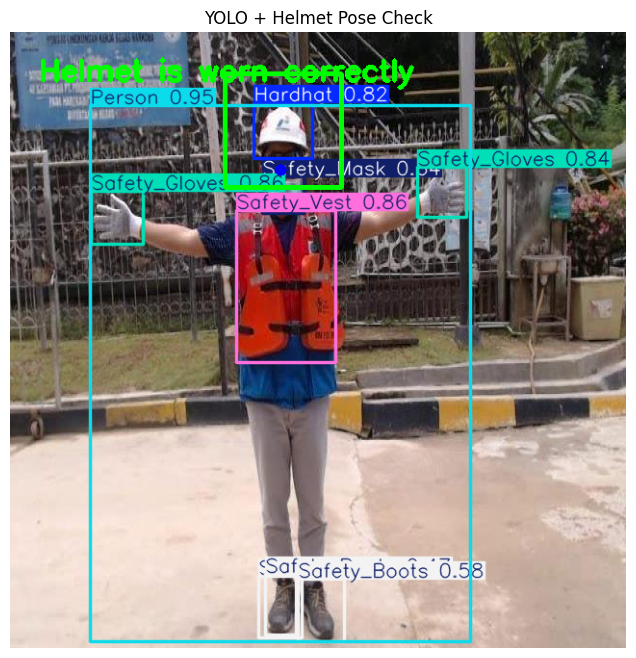

In [22]:
run_combined_detection('/kaggle/input/ppedata/Final_PPE_Dataset/test/images/test_Hardhat_000245.jpg', model)


image 1/1 /kaggle/input/ppedata/Final_PPE_Dataset/train/images/train_Hardhat_000006.jpg: 640x640 1 Hardhat, 1 Person, 1 Safety_Vest, 10.2ms
Speed: 1.7ms preprocess, 10.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


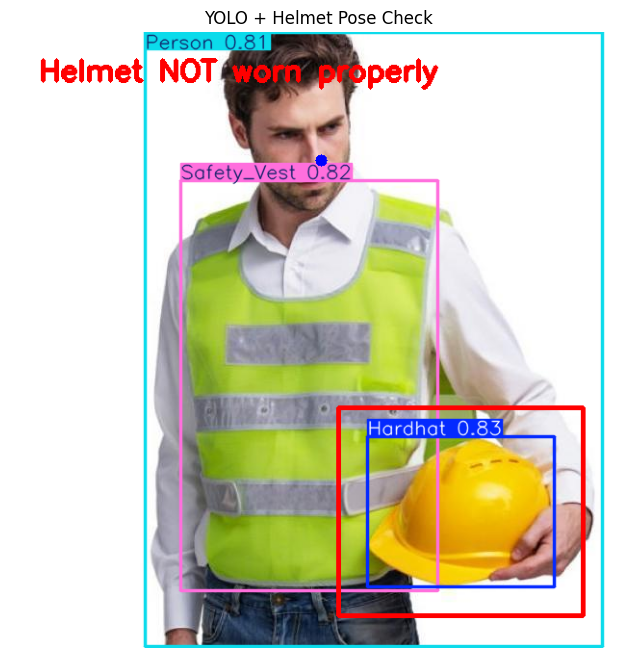

In [23]:
run_combined_detection('/kaggle/input/ppedata/Final_PPE_Dataset/train/images/train_Hardhat_000006.jpg', model)


image 1/1 /kaggle/input/ppedata/Final_PPE_Dataset/test/images/test_Person_000001.jpg: 640x640 1 Person, 1 Safety_Vest, 10.3ms
Speed: 1.7ms preprocess, 10.3ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)


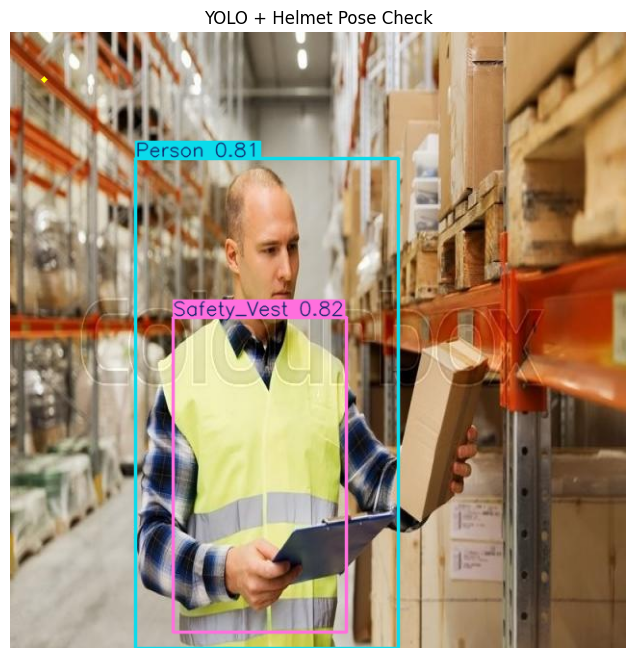

In [24]:
run_combined_detection('/kaggle/input/ppedata/Final_PPE_Dataset/test/images/test_Person_000001.jpg', model)


image 1/1 /kaggle/input/ppedata/Final_PPE_Dataset/test/images/test_Hardhat_000221.jpg: 640x640 1 Hardhat, 2 Safety_Bootss, 10.5ms
Speed: 1.8ms preprocess, 10.5ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)


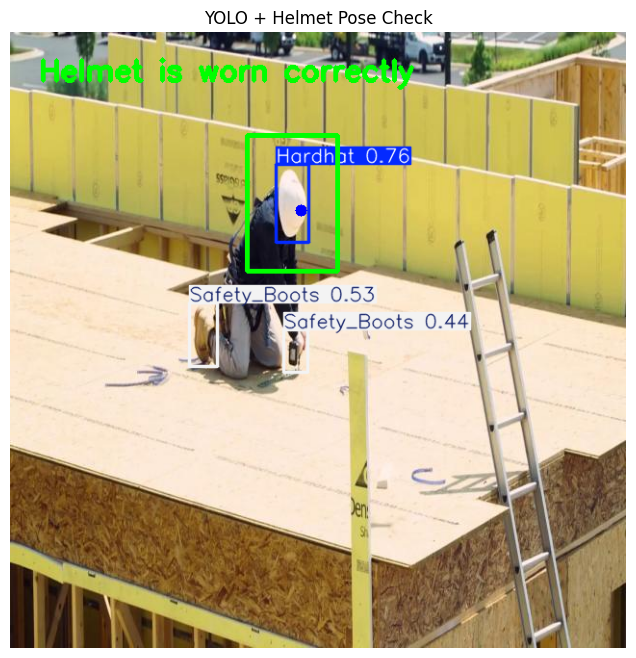

In [27]:
run_combined_detection('/kaggle/input/ppedata/Final_PPE_Dataset/test/images/test_Hardhat_000221.jpg', model)


image 1/1 /kaggle/input/ppedata/Final_PPE_Dataset/test/images/test_Safety_Vest_000149.jpg: 640x640 1 Hardhat, 1 Person, 1 Safety_Vest, 10.3ms
Speed: 2.0ms preprocess, 10.3ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)


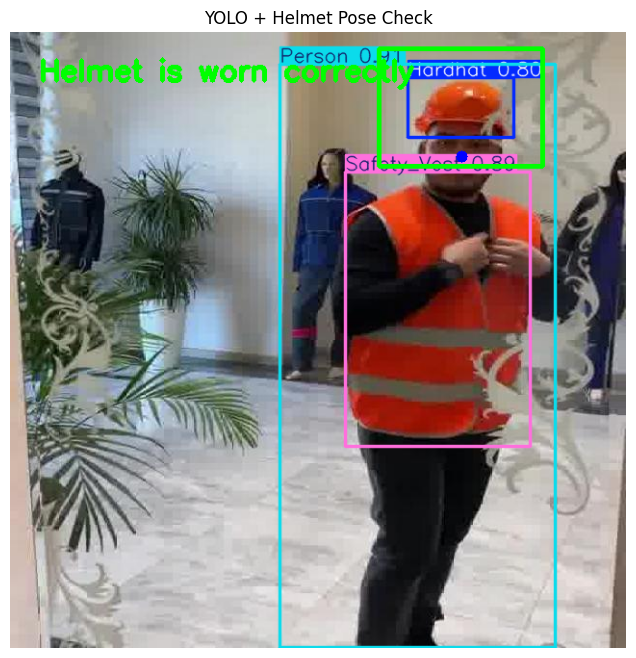

In [28]:
run_combined_detection('/kaggle/input/ppedata/Final_PPE_Dataset/test/images/test_Safety_Vest_000149.jpg', model)

In [ ]:
# only prediction 

In [ ]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
import random
import os
# Step 2: Visualize predictions on test set
def visualize_predictions(model, test_path, num_samples=10):
    images_path = os.path.join(test_path, 'images')
    if not os.path.exists(images_path):
        print(f"Test images directory not found at {images_path}")
        return
    
    image_files = [f for f in os.listdir(images_path) if f.endswith(('.jpg', '.jpeg', '.png'))]
    if not image_files:
        print(f"No image files found in {images_path}")
        return
    
    selected_files = random.sample(image_files, min(num_samples, len(image_files)))
    
    for img_file in selected_files:
        img_path = os.path.join(images_path, img_file)
        
        # Perform prediction
        results = model.predict(img_path, conf=0.25, save=False)
        
        # Plot results
        for r in results:
            im_array = r.plot()  # Plot with detections (returns a BGR image)
            # Convert BGR to RGB for matplotlib
            im_array = cv2.cvtColor(im_array, cv2.COLOR_BGR2RGB)
            plt.figure(figsize=(12, 8))
            plt.imshow(im_array)
            plt.title(f"Predictions on {img_file}")
            plt.axis('off')
            plt.show()


# Visualize predictions
print("\nVisualizing predictions on test set...")
visualize_predictions(model, test_path, num_samples=10)